In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats
from sklearn import metrics

!pip install pmdarima --quiet
import pmdarima as pm
pd.plotting.register_matplotlib_converters()

### Time Series Forecasting: Prediction Intervals

Forecasting in the real world is an important task. Consider forecasting energy demand, temperature, food supply, and health indicators just to name a few. Getting an inaccurate forecast in these cases can have a significant impact on people's lives. 

This is where prediction intervals can help. Prediction intervals are used to provide a range where the forecast is likely to be with a specific degree of confidence. For example, if you made 100 forecasts with 95% confidence, you would have 95 out of 100 forecasts fall within the prediction interval. By using a prediction interval you can account for uncertainty in the forecast, and the random variation of the data.

### Loading Data

In this article, we will be forecasting the average monthly temperature in Sau Paulo, Brazil. The data set was collected and curated by NCEI and NASA. Thank you to everyone involved for sharing this dataset with the world! (License: CC0 - Public Domain)

Unfortunately in the real world, data is never in the format that you want. In the following cell, we use Pandas to transform it into two columns. Date and Temperature. The resulting data is visualized using Matplotlib.

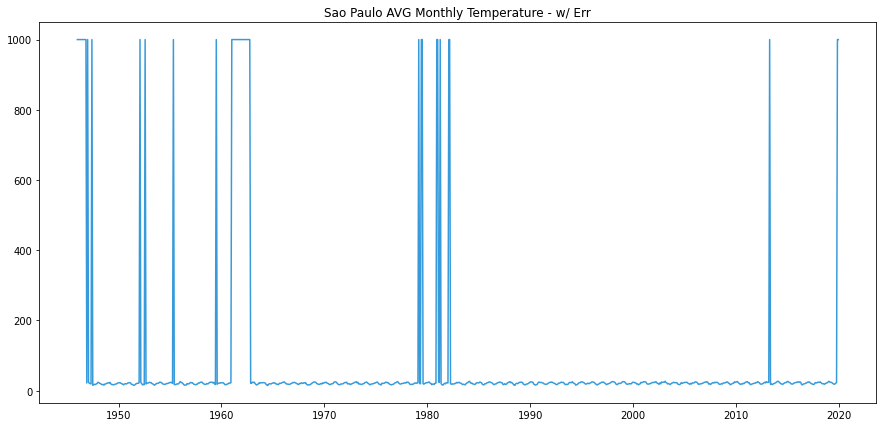

In [2]:
# ---- Data Transformations ----
months_dict = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
               'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

df = pd.read_csv('../input/temperature-timeseries-for-some-brazilian-cities/station_sao_paulo.csv')
df = df[['YEAR'] + list(months_dict.keys())]

df_sp = pd.melt(df, 
        id_vars='YEAR',
        value_vars=months_dict.keys(),
        var_name='MONTH', 
        value_name='Sum of Value').replace({"MONTH": months_dict})

df_sp['DAY'] = 1 #need a day for the pd.to_datetime() function
df_sp['DATE'] = pd.to_datetime(df_sp[['YEAR','MONTH','DAY']])
df_sp = df_sp[['DATE','Sum of Value']].rename(columns={'DATE':'date','Sum of Value':'temp'})
df_sp = df_sp.sort_values('date').reset_index(drop=True)

# ---- Visualize Data ----
plt.figure(figsize=(15,7))
plt.title("Sao Paulo AVG Monthly Temperature - w/ Err")
plt.plot(df_sp["date"], df_sp['temp'], color='#379BDB', label='Original')
plt.show(block=False)

In the plot above, we can see that the dataset has missing values and errors. These points are filled with temperatures of 999.9. We can simply sample 372 data points between ~1980 and ~2015 that contain no errors. We will use this sample of data for the rest of the article.

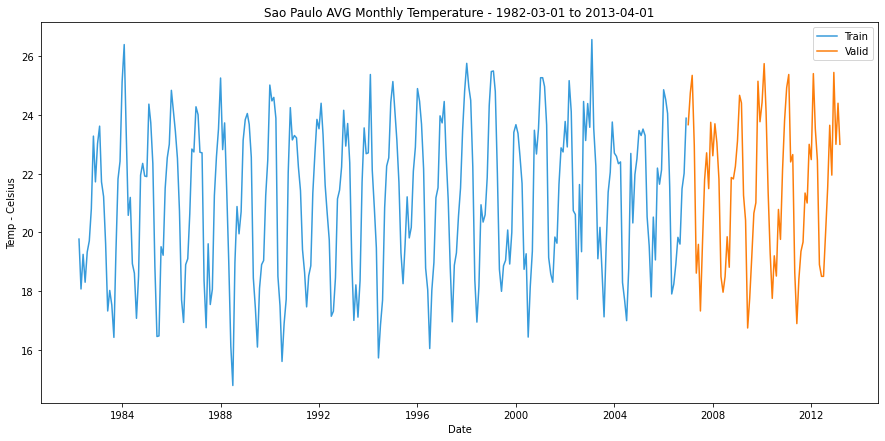

In [3]:
df_sp = df_sp[(df_sp['date'] > '1982-03-01') & (df_sp['date'] < '2013-04-01')]
df_sp = df_sp.set_index(df_sp['date'], drop=True).drop(columns=["date"])

train, valid = df_sp[:int(len(df_sp)*0.8)], df_sp[int(len(df_sp)*0.8):]

plt.figure(figsize=(15,7))
plt.title("Sao Paulo AVG Monthly Temperature - 1982-03-01 to 2013-04-01")
plt.plot(train.index, train['temp'], color='#379BDB', label='Train')
plt.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
plt.xlabel('Date')
plt.ylabel('Temp - Celsius')
plt.legend()
plt.show(block=False)

## Defining Model

I have worked with many time series models in the past, but I always come back to ARIMA models. These models are reliable and regularly outperform competing model types (NeuralProphet, ExponentialSmoothing, Last-Value). 

We will use a modified version of ARIMA called SARIMA. This adds another lagged term that keeps track of seasonailty in the data. Using a package in called pmdarima we can automatically tune the model parameters. For a more detailed explanation on ARIMA models check out this amazing article [here](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6).


In [4]:
# Seasonal - Find best parameters with Auto-ARIMA
SARIMA_model = pm.auto_arima(train['temp'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #annual frequency(12 for month, 7 for week etc) 
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

The cell above gives us the optimal order, and seasonal order to fit our ARIMA model with. In the following cell we do just that, and iteratively make 1-step predictions on the validation dataset.

In [5]:
%%time

sarima_preds = []
df_sp.index = df_sp.index.to_period('M') 

for i in range(len(valid)):
    m_sarima = ARIMA(df_sp[:len(train)+i]['temp'], order=(1,0,0), seasonal_order=(0, 1, 2, 12)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])
    
residuals = sorted([x - y for x, y in zip(sarima_preds, valid['temp'].values)])

CPU times: user 3min 49s, sys: 3min 26s, total: 7min 15s
Wall time: 1min 50s


# Prediction Intervals 

Now we have a set of predictions we can build a prediction interval.

#### Method 1: RMSFE

The first method that we can use is called RMSFE(root mean squared forecasting error). RMSFE is very similar to RMSE. The only difference is that RMSFE has to be calculated on residual terms from predictions on unseen data (ie. Validation or Test set). 

It's important to note that we can only use this method if we assume that the residuals of our validation predictions are normally distributed. To see if this is the case, we will use a PP-plot and test its normality with the Anderson-Darling, Kolmogorov-Smirnov, and D’Agostino K^2 tests.

The PP-plot(Probability-to-Probability) plots the data sample against the normal distribution plot in such a way that if normally distributed, the data points will form a straight line.

The three normality tests determine how likely a data sample is from a normally distributed population using p-values. The null hypothesis for each test is that "the sample came from a normally distributed population". This means that if the resulting p-values are below a chosen alpha value, then the null hypothesis is rejected. Thus there is evidence to suggest that the data comes from a non-normal distribution. For this article, we will use an Alpha value of 0.01.

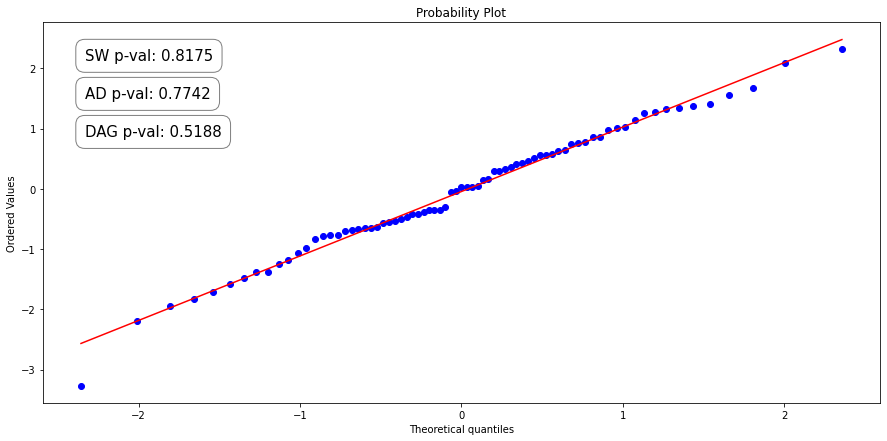

In [6]:
sw_result = stats.shapiro(residuals)
ad_result = normal_ad(np.array(residuals), axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

Great! All three tests returned a p-value greater than the alpha value of 0.01. That means that the null hypothesis can not be rejected and it is likely that the data points come from a normal distribution. We can now use RMSFE to generate prediction intervals on our forecast.

The first step here is to choose the degree of confidence that we want to provide. Do we want our prediction to fall within the prediction interval 75%, 95%, or 99% of the time? We will use a prediction interval of 95%. In a normal distribution, 95% of data points fall within 1.96 standard deviations of the mean, so we multiply 1.96 by the RMSFE to get get the prediction interval size. This is shown in the plot below.

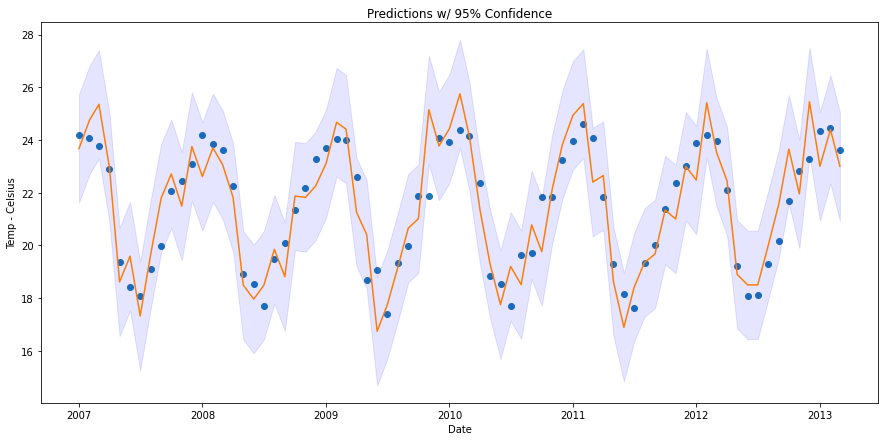

In [7]:
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)
ax.fill_between(valid.index, (valid['temp']-band_size), (valid['temp']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()

The downside of this method is that the prediction interval is highly dependent on the residuals from the validation predictions. This is not the end of the world, but the prediction interval is likely overfitting to the variation in the validation set.

### Method 2: BCVR (Bootstrapping Cross-Validation Residuals)

NOTE: This is a theoretical method I am proposing!

Lets call this method BCVR (Bootstrapping Cross-Validation Residuals). BCVR is an attempt to reap the benefits of both cross-validation and bootstrapping. Bootstrapping residuals is a common way to generate prediction intervals, and typically yields similar results to the RMSFE method with normally distributed residuals, but performs slightly better than RMSFE on non-normal residuals. Futhermore, by using cross-validation, BCVR should generate a residual distribution that is more representative of the entire dataset.

We can start by performing cross-validation to generate residuals. We randomly select a training sample that is between 250 and 372 points long and make a one-step forecast. Then, we calculate the residual for this prediction and repeat the process 1000 times. 

In [8]:
%%time

crossval_count = 1000
min_size = 250
max_random = len(df_sp) - (min_size)

crossval_resids = []

for b in range(crossval_count):
    start, end = [min_size*i+x for i, x in enumerate(sorted([np.random.randint(max_random) for y in range(2)]))]
    
    m_sarima = ARIMA(df_sp[start:end]['temp'], order=(1,0,0), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False).fit()
    pred = m_sarima.forecast(1).values[0]
    crossval_resids.append(pred - df_sp[end:end+1]['temp'].values[0])
    
bsed_residuals = sorted(crossval_resids)

CPU times: user 41min 40s, sys: 37min 21s, total: 1h 19min 1s
Wall time: 20min 12s


Then, we can test the normality of the residual distribution. 

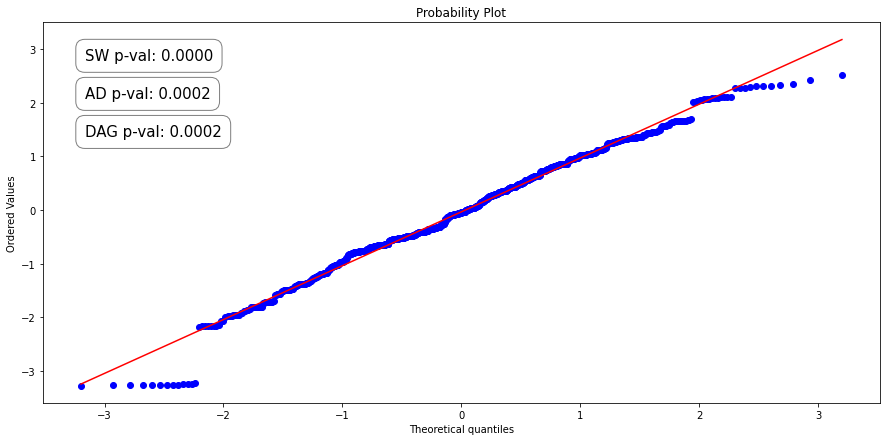

In [9]:
sw_result = stats.shapiro(bsed_residuals)
ad_result = normal_ad(np.array(bsed_residuals), axis=0)
dag_result = stats.normaltest(bsed_residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(bsed_residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

Oh no! We have p-values that fall below the Alpha threshold so should reject the null hypothesis? No. We can use a technique called bootstrapping to get a measure of the residual variance. To do this, we take the cross-validated residuals and perform random sampling with replacement. We then compute the standard deviation of the resampled set and store this in an array. We repeat this process several times, and then take the mean/median of the stored bootstrapped standard deviations.

There is no consensus among mathematicians as to how many times one should bootstrap, but I am proposing an early stopping to reduce computation demand. In the following implementation, we check the mean standard deviation of the bootstrapped samples every 200 iterations. If the mean standard deviation does not deviate by more than 0.1% from its value, then we terminate the loop. This is shown in the cell below.

Early Stopping Iteration: 7500
Median of Bootstrapped STD's: 1.0073


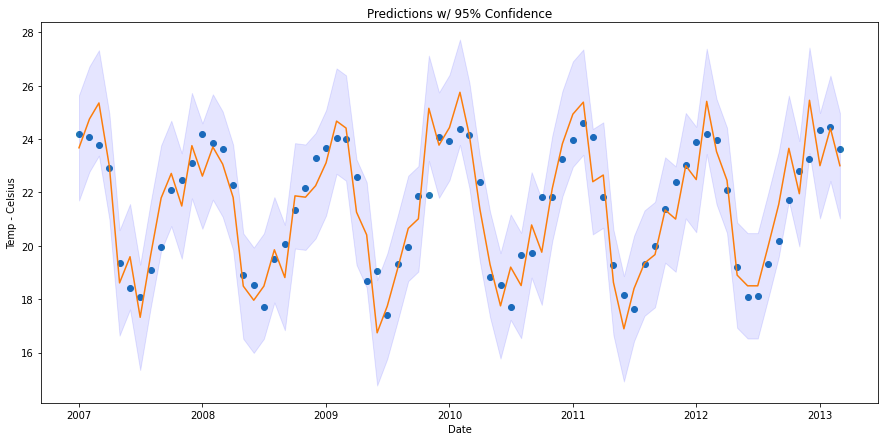

In [10]:
bs_stds=[]
last_std = None

for i in range(10000):
    samples = [bsed_residuals[np.random.randint(len(bsed_residuals))] for x in range(len(bsed_residuals))]
    bs_stds.append(np.std(samples))
    if i%500 == 0 and i!=0:
        if i == 500:
            last_std = np.median(bs_stds)
        else:
            current_std = np.median(bs_stds)
            if abs(current_std - last_std) < last_std*0.00001:
                print("Early Stopping Iteration: {}".format(i))
                break
            else:
                last_std = np.median(bs_stds)        
    
bs_std = np.median(bs_stds)
print("Median of Bootstrapped STD's: {:.4f}".format(bs_std))

bs_band_size = 1.96*bs_std 

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)
ax.fill_between(valid.index, (valid['temp']-bs_band_size), (valid['temp']+bs_band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')
plt.show()

The downside of the BCVR approach is that it is computationally expensive for one machine. Thankfully this method is well-suited for clustered computing. This means that the workload can be divided among multiple machines. For example, if we had a cluster with 10 nodes and wanted to perform 1000 bootstapped samples, we could have each node perform 100 samples at the same time. This would dramatically reduce the compute time and allow us to increase the number of bootstrapped samples.

### RMSFE vs Bootstrapping Cross-Validation Residuals

How do the two methods compare? In both cases, all 75 points fall within the prediction interval. Although unlikely (2% chance), there are points that fall very close the the boundary. The two methods are slighlty differnet in their interval range. The BCVR approach produces a slightly narrower prediction interval range than the RMSFE approach.

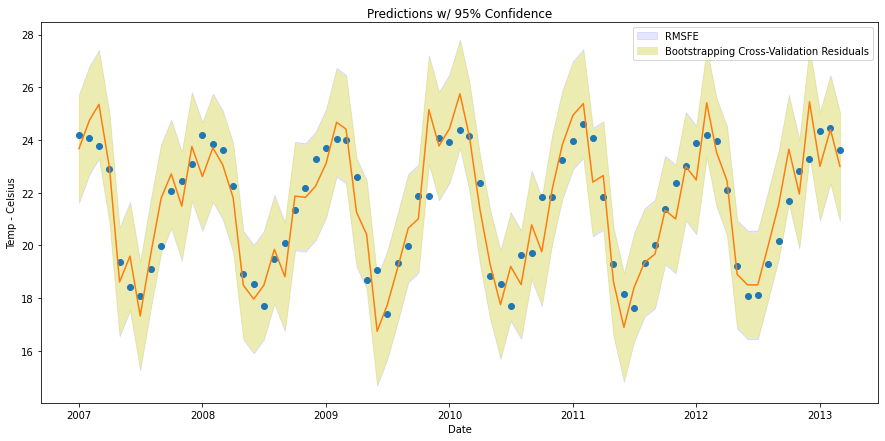

In [11]:
bs_band_size = 1.96*bs_std 

fig, ax = plt.subplots(figsize=(15,7))
ax.fill_between(valid.index, (valid['temp']-band_size), (valid['temp']+band_size), color='blue', alpha=0.1)
ax.fill_between(valid.index, (valid['temp']-bs_band_size), (valid['temp']+bs_band_size), color='yellow', alpha=0.3)

ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)

ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Temp - Celsius')

patches = [Patch(color='blue', alpha=0.1), Patch(color='#ececb2')]
labels = ['RMSFE','Bootstrapping Cross-Validation Residuals']
ax.legend(patches, labels)

plt.show()

### Final Thoughts

This example indicates that the BCVR test could be useful in generating a prediction interval more representative of the entire population. It would be interesting to see how applicable it is across different use cases. If you do so please let me know!

### References 

- https://otexts.com/fpp2/prediction-intervals.html
- https://www.real-statistics.com/regression/confidence-and-prediction-intervals/#:~:text=The%20confidence%20interval%20consists%20of,concept%20called%20a%20prediction%20interval
- https://towardsdatascience.com/add-prediction-intervals-to-your-forecasting-model-531b7c2d386c
- https://www.ncei.noaa.gov/
- https://data.giss.nasa.gov/gistemp/
- http://alkaline-ml.com/pmdarima/1.8.3/modules/classes.html
- https://stats.stackexchange.com/questions/90697/is-shapiro-wilk-the-best-normality-test-why-might-it-be-better-than-other-tests
- https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
- https://www.geeksforgeeks.org/normal-probability-plot/
- https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
- https://saattrupdan.github.io/2020-03-01-bootstrap-prediction/